
## Instruction
- In this assignment, we're going to classify the images in the CIFAR10 dataset into 10 categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) using Convolutional Neural Networks.
- 1) First, we're going to create the Convolutional Neural Network layer by ourselves with some help of pytorch library. Before we start, I recommend you to go through Assignment3_pytorch_tutorial.ipynb. Some functions introduced in the tutorial will help you.
- 2) Second, we're going to build a CNN model and take a look at how well it performs as it classifies images in the CIFAR10 dataset. From what we learned, the accuracy can be around 82%, or even higher. Try to maximize the accuracy on the test set.
- 3) Train your own CNN model and show the results.



## PyTorch Documentation
- You can refer to the PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html

---




## Prerequisite: change the runtime type to **GPU**.


![test](https://docs.google.com/uc?export=download&id=17Hfh0B6FuxWDs8Q3aIQjizALtiinwQ72)

---


## Step 0-1: Import modules

In [ ]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as  np
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Step 0-2: Experiment configuration

In [ ]:
# training & optimization hyper-parameters
max_epoch = 100
learning_rate = 0.1
batch_size = 512
device = 'cuda'

## Step 1: Data pipeline construction

**`torchvision.datasets.CIFAR10`** will automatically construct **`CIFAR10`** dataset.

In [ ]:
data_dir = "./my_data"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output_dim = len(classes)

Files already downloaded and verified
Files already downloaded and verified


## Step 2: Build your neural network.

Build your own convolutional neural network layer.
- Do not use convolutional operations from torch like nn.Conv2d or F.Conv2d
- The operations in the tutorial are enough for this step.


In [ ]:
# Let's build your own CNN
class My_Conv2d(nn.Module):
    def __init__(self, in_feature, n_filter, filter_size, stride, pad):
        # create your own convolutional layer
        # your convolutional layer will be initialized with
        #  1. input feature dimension (in_feature(int))
        #  2. the number of filters (n_filter(int))
        #  3. the size of filter(filter_size(int))
        #  4. stride
        #  5. number of paddings
        # For simplicity, we assume that all filters are square filters
        # the shape of your filter should be n_filter x in_feature x filter_size x filter_size
        super(My_Conv2d, self).__init__()
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 2-1. define the parameters for CNN
        self.filter_size = filter_size
        self.in_feature = in_feature
        self.n_filter = n_filter
        self.filters = nn.Parameter(torch.zeros((n_filter, in_feature, filter_size, filter_size), requires_grad = True))
        self.bias = nn.Parameter(torch.zeros((1,n_filter,1,1),  requires_grad = True))
        self.stride = stride
        self.pad = pad

        torch.nn.init.xavier_uniform_(self.filters)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


    def forward(self,x):
        # the size of the input will be n_batch x in_feature x H x W
        # the size of the output should be n_batch x n_filter x H' x W' where H', W' are the image size after convolution
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 2-2. Calculate the size of new images
        new_h = (x.shape[2]-self.filter_size+2*self.pad)//self.stride+1
        new_w = (x.shape[3]-self.filter_size+2*self.pad)//self.stride+1
        # 2-3. pad the input x
        padded_x = F.pad(x, pad = (self.pad, self.pad, self.pad, self.pad))
        # 2-4. Precalculate the strided verison of the padded input
        strided = torch.as_strided(padded_x, (padded_x.shape[0], padded_x.shape[1], new_h, new_w, self.filter_size, self.filter_size), \
                                   (padded_x.shape[1]*padded_x.shape[2]*padded_x.shape[3], padded_x.shape[2]*padded_x.shape[3],  self.stride * padded_x.shape[3], self.stride, padded_x.shape[3], 1))
        # 2-5. Calculate the CNN result
        result_x = torch.tensordot(self.filters, strided, dims=([1,2,3],[1,4,5])).transpose(0,1)+self.bias
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return result_x

## Step 3: Now, build your own CNN model based on My_Conv2d.

- You must use My_Conv2d for convolutional operations

- You may use other functions such as nn.MaxPool2d or nn.Linear

- Try to create a model that can achieve 80% accuracy or higher on the test set

In [ ]:
# Let's build your own model.

class MyOwnClassifier(nn.Module):
    def __init__(self):
        super(MyOwnClassifier, self).__init__()
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 3-1. Define your own layers
        self.conv1 = My_Conv2d(3, 64, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, stride = 2)
        self.dropout1 = nn.Dropout()
        self.conv2 = My_Conv2d(64, 128, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, stride = 2)
        self.dropout2 = nn.Dropout()
        self.conv3 = My_Conv2d(128, 256, 3, 1, 1)
        self.maxpool3 = nn.MaxPool2d(2, stride = 2)
        self.dropout3 = nn.Dropout()
        self.fcn1 = nn.Linear(256*4*4, 256)
        self.dropout4 = nn.Dropout()
        self.fcn2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*******


    def forward(self, x):
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 3-2. Pass the input through the layer
        x1 = self.dropout1(self.maxpool1(self.relu(self.conv1(x))))
        x2 = self.dropout2(self.maxpool2(self.relu(self.conv2(x1))))
        x3 = self.dropout3(self.maxpool3(self.relu(self.conv3(x2))))
        x4 = self.dropout4(self.relu(self.fcn1(torch.flatten(x3, start_dim = 1))))
        output = self.fcn2(x4)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*******
        return output

## Step 4: Initialize the network and optimizer.

In [ ]:
my_classifier = MyOwnClassifier()
my_classifier = my_classifier.to(device)

# Print your neural network architecture
print(my_classifier)

optimizer = optim.SGD(my_classifier.parameters(), lr=learning_rate)

MyOwnClassifier(
  (conv1): My_Conv2d()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): My_Conv2d()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): My_Conv2d()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fcn1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fcn2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)



## Step 5: Train the network

In [ ]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    epoch_loss = 0
    epoch_acc = 0
    n_train = 0
    for inputs, labels in train_dataloader:

        # load data to the GPU.
        # 5-1. Send 'inputs' and 'labels' to either cpu or gpu using the 'device' variable
        inputs = inputs.to(device)
        labels = labels.to(device)

        # feed data into the network and get outputs.
        # 5-2. Feed `inputs` into the network, get an output, and keep it in a variable called `logits`.
        logits = my_classifier(inputs)

        # calculate loss
        # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
        # 5-3. Compute loss using `logits` and `labels`, and keep it in a variable called `loss`
        loss = F.cross_entropy(logits, labels)

        # Note: You should flush out gradients computed in the previous step before computing gradients in the current step.
        #       Otherwise, gradients will accumulate.
        # 5-4. flush out the previously computed gradient
        # write your code here (one-liner).
        optimizer.zero_grad()

        # backpropagate loss.
        # 5-5. backward the computed loss.
        # write your code here (one-liner).
        loss.backward()

        # 5-6. update the network weights.
        # write your code here (one-liner).
        optimizer.step()

        # Gather loss and accuracy for visualization
        epoch_loss += loss.item()*inputs.size(0)
        epoch_acc += (logits.argmax(dim=1) == labels).float().sum().item()
        n_train += inputs.size(0)

    # save losses and accuracies in a list so that we can visualize them later.
    epoch_loss /= n_train
    epoch_acc /= n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)


    # test phase
    n_test = 0.
    test_loss = 0.
    test_acc = 0.

    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
        # 5-6. Send 'test_inputs' and 'test_labels' to either cpu or gpu using the 'device' variable
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        # 5-7. Feed `inputs` into the network, get an output, and keep it in a variable called `logits`.
        logits = my_classifier(test_inputs)

        # calculate loss
        # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
        # 5-8. Compute loss using `logits` and `labels`, and keep it in a variable called `tmp_loss`
        tmp_loss = F.cross_entropy(logits, test_labels, reduction='sum')

        # Gather loss and accuracy for visualization
        test_loss += tmp_loss.item()
        test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
        n_test += test_inputs.size(0)

    test_loss /= n_test
    test_acc /= n_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print('[epoch:{}] train loss : {:.4f} train accuracy : {:.4f} test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch+1, epoch_loss, epoch_acc, test_loss, test_acc))



[epoch:1] train loss : 2.1354 train accuracy : 0.2073 test_loss : 2.0412 test accuracy : 0.2723
[epoch:2] train loss : 1.8813 train accuracy : 0.3155 test_loss : 1.8398 test accuracy : 0.3456
[epoch:3] train loss : 1.7327 train accuracy : 0.3713 test_loss : 1.6548 test accuracy : 0.4244
[epoch:4] train loss : 1.6213 train accuracy : 0.4119 test_loss : 1.5647 test accuracy : 0.4769
[epoch:5] train loss : 1.5434 train accuracy : 0.4428 test_loss : 1.5581 test accuracy : 0.4544
[epoch:6] train loss : 1.4841 train accuracy : 0.4642 test_loss : 1.4600 test accuracy : 0.4881
[epoch:7] train loss : 1.4380 train accuracy : 0.4801 test_loss : 1.3643 test accuracy : 0.5331
[epoch:8] train loss : 1.3915 train accuracy : 0.4981 test_loss : 1.3848 test accuracy : 0.5205
[epoch:9] train loss : 1.3538 train accuracy : 0.5140 test_loss : 1.3136 test accuracy : 0.5369
[epoch:10] train loss : 1.3255 train accuracy : 0.5250 test_loss : 1.2523 test accuracy : 0.5671
[epoch:11] train loss : 1.2874 train ac

## Step 6: Visualization

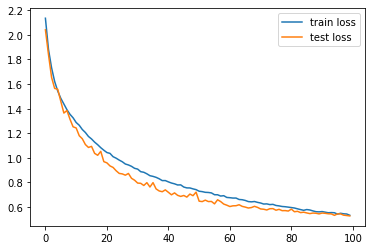

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

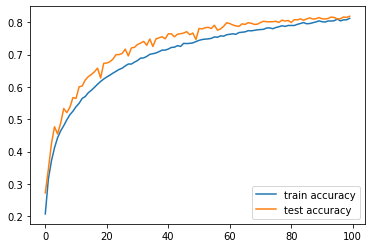

In [ ]:
plt.clf()
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()

label : cat
prediction : cat


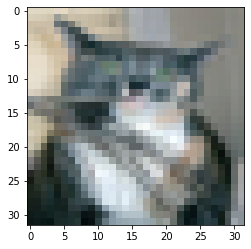

In [ ]:
my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.243 + 0.4822
    img[2] = img[2] * 0.261 + 0.4465
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images
imshow(torchvision.utils.make_grid(test_input))